In [48]:
import pandas as pd
import pathlib
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


In [28]:
work_path = pathlib.Path.cwd()
data_path = Path(work_path, 'data', 'Telco-Customer-Churn.csv')
data = pd.read_csv(data_path)


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# EDA

In [30]:
data['Churn'] = np.where(data['Churn'] == 'Yes', 1, 0)
data['Partner'] = np.where(data['Partner'] == 'Yes', 1, 0)
data['Dependents'] = np.where(data['Dependents'] == 'Yes', 1, 0)
data['PhoneService'] = np.where(data['PhoneService'] == 'Yes', 1, 0)
data['PaperlessBilling'] = np.where(data['PaperlessBilling'] == 'Yes', 1, 0)
data['gender'] = np.where(data['gender'] == 'Male', 1, 0)

In [31]:
two_categorical_column = []
other_categorical_column = []
for column in data.columns[1:-3].drop('tenure'):
    if len(data[column].unique()) == 2:
        two_categorical_column.append(column)
    else:
        other_categorical_column.append(column)
    print('Количество уникальных значений {0} = {1}'.format(column, data[column].unique()))

Количество уникальных значений gender = [0 1]
Количество уникальных значений SeniorCitizen = [0 1]
Количество уникальных значений Partner = [1 0]
Количество уникальных значений Dependents = [0 1]
Количество уникальных значений PhoneService = [0 1]
Количество уникальных значений MultipleLines = ['No phone service' 'No' 'Yes']
Количество уникальных значений InternetService = ['DSL' 'Fiber optic' 'No']
Количество уникальных значений OnlineSecurity = ['No' 'Yes' 'No internet service']
Количество уникальных значений OnlineBackup = ['Yes' 'No' 'No internet service']
Количество уникальных значений DeviceProtection = ['No' 'Yes' 'No internet service']
Количество уникальных значений TechSupport = ['No' 'Yes' 'No internet service']
Количество уникальных значений StreamingTV = ['No' 'Yes' 'No internet service']
Количество уникальных значений StreamingMovies = ['No' 'Yes' 'No internet service']
Количество уникальных значений Contract = ['Month-to-month' 'One year' 'Two year']
Количество уникальных

In [32]:
ohe = OneHotEncoder()
ohe_data = pd.DataFrame(ohe.fit_transform(data[other_categorical_column]).toarray(), columns=ohe.get_feature_names_out())

In [33]:
data.drop(other_categorical_column + ['customerID'], axis=1, inplace=True)
data = pd.concat([data, ohe_data], axis=1)

In [34]:
data.loc[data.TotalCharges == ' ', 'TotalCharges'] = np.nan
data.dropna(axis=0, inplace=True)
data['TotalCharges'] = data['TotalCharges'].astype(float)
#data['TotalCharges'].fillna((data['TotalCharges'].mode()), inplace=True)

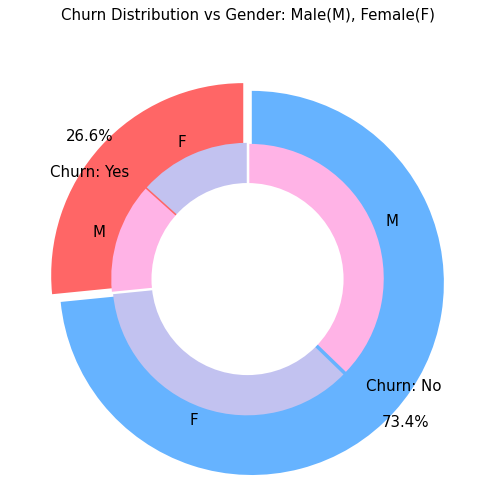

In [35]:
plt.figure(figsize=(7, 7))
labels =["Churn: Yes","Churn: No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939, 930, 2544, 2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3, 0.3) 
explode_gender = (0.1, 0.1, 0.1, 0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels, autopct='%1.1f%%', pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )

#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution vs Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

# Машинное обучение

In [36]:
X = data.drop('Churn', axis=1)
y = data['Churn']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=42)

# Случайный лес

In [38]:
forest = RandomForestClassifier()

In [39]:
#Choosing best hyperparameters:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(100, 1200, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [40]:
# Create the random grid for these hyperparameters:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 222, 344, 466, 588, 711, 833, 955, 1077, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [41]:

random_grid = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs =-1)


In [42]:
random_grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 222, 344, 466,
                                                         588, 711, 833, 955,
                                                         1077, 1200]},
                   random_state=42, verbose=2)

In [43]:
print(random_grid.best_params_)
print(random_grid.best_score_)

{'n_estimators': 711, 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
0.8058424238063975


In [53]:
forest = RandomForestClassifier(n_estimators=711, min_samples_split=100, 
random_state=0, min_samples_leaf=2, max_features='sqrt', max_depth=15)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=100, n_estimators=711, random_state=0)

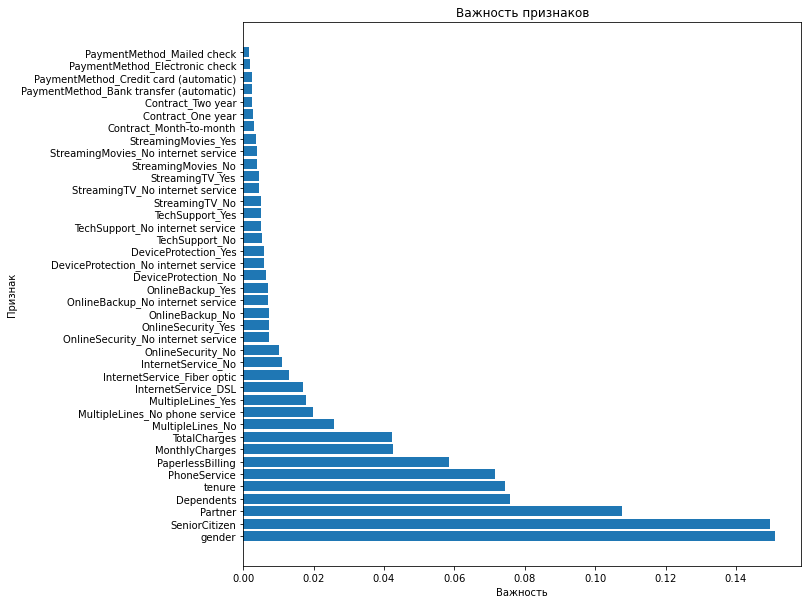

In [74]:
importance = pd.DataFrame({'features': X.columns, 'feature_importances_':forest.feature_importances_,})
importance = importance.sort_values(by='feature_importances_', ascending=False)
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
def plot_feature_importances_cancer(data):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(n_features), data.feature_importances_)
    plt.yticks(np.arange(n_features), X.columns)
    plt.ylabel("Признак")
    plt.xlabel('Важность')
    plt.title('Важность признаков')

plot_feature_importances_cancer(importance)


In [46]:
predict_forest = forest.predict(X_test)

In [75]:
print(confusion_matrix(y_test,predict_forest))
print(classification_report(y_test, predict_forest))
print(accuracy_score(y_test, predict_forest))

[[1154  146]
 [ 229  229]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1300
           1       0.61      0.50      0.55       458

    accuracy                           0.79      1758
   macro avg       0.72      0.69      0.71      1758
weighted avg       0.78      0.79      0.78      1758

0.7866894197952219


In [ ]:
predictions = random_grid.predict(X_test)

In [ ]:

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1176  106]
 [ 241  238]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1282
           1       0.69      0.50      0.58       479

    accuracy                           0.80      1761
   macro avg       0.76      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761

0.8029528676888131


# Метод к ближайщих соседей

In [ ]:

error_rate=list()
#here we iterate meny different k values and plot their error rates 
#and discover which one is better than others and has the lowest error rate
for i in range(1, 40):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    prediction_i=knn.predict(X_test)
    error_rate.append(np.mean(prediction_i != y_test))

Text(0, 0.5, 'Error Rate')

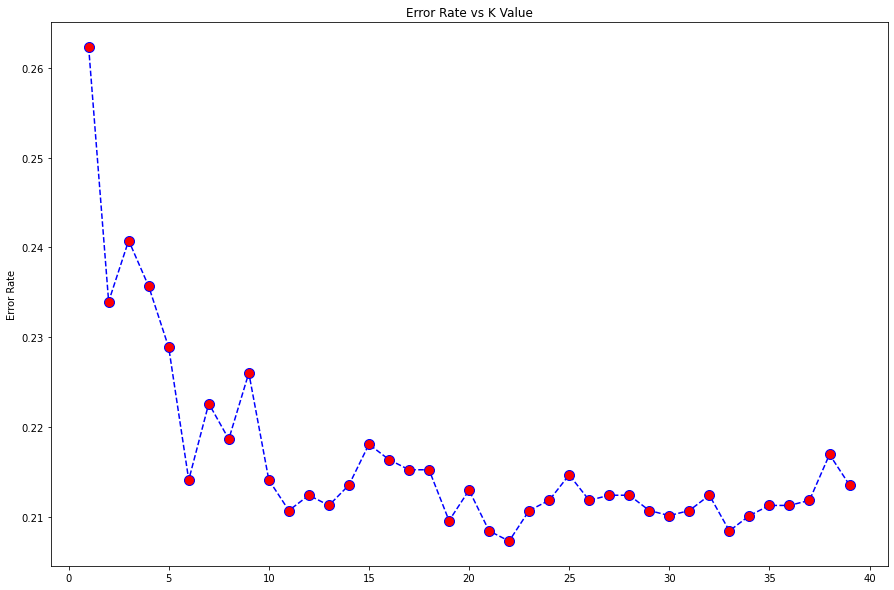

In [ ]:

plt.figure(figsize=(15,10))
plt.plot(range(1,40),error_rate, color="blue", linestyle="--",marker="o",markerfacecolor="red",markersize=10)
plt.title("Error Rate vs K Value")
plt.xlabel="K Value"
plt.ylabel("Error Rate")

In [ ]:
knn=KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
predictions=knn.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1194   88]
 [ 283  196]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1282
           1       0.69      0.41      0.51       479

    accuracy                           0.79      1761
   macro avg       0.75      0.67      0.69      1761
weighted avg       0.78      0.79      0.77      1761

0.7893242475865985


# Дерево решений

In [ ]:

dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
print(tree.export_text(dtree))

|--- feature_33 <= 0.50
|   |--- feature_7 <= 93.67
|   |   |--- feature_35 <= 0.50
|   |   |   |--- feature_32 <= 0.50
|   |   |   |   |--- feature_38 <= 0.50
|   |   |   |   |   |--- feature_12 <= 0.50
|   |   |   |   |   |   |--- feature_8 <= 37.08
|   |   |   |   |   |   |   |--- feature_8 <= 35.35
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_8 >  35.35
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_8 >  37.08
|   |   |   |   |   |   |   |--- feature_36 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_8 <= 147.50
|   |   |   |   |   |   |   |   |   |--- feature_8 <= 140.88
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_8 >  140.88
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_8 >  147.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_36 >  0.50
|   | 

In [ ]:
predictions = dtree.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1049  233]
 [ 239  240]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1282
           1       0.51      0.50      0.50       479

    accuracy                           0.73      1761
   macro avg       0.66      0.66      0.66      1761
weighted avg       0.73      0.73      0.73      1761

0.7319704713231119


# Метод опорных векторов

In [ ]:



param_grid={"C":[1,5,10],"gamma":[1, 0.01, 0.001]} 
#here we select values for grid search to try
grid=GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_train,y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................................C=1, gamma=1; total time=   3.0s
[CV] END .......................................C=1, gamma=1; total time=   3.2s
[CV] END .......................................C=1, gamma=1; total time=   3.5s
[CV] END .......................................C=1, gamma=1; total time=   3.5s
[CV] END .......................................C=1, gamma=1; total time=   2.8s
[CV] END ....................................C=1, gamma=0.01; total time=   2.8s
[CV] END ....................................C=1, gamma=0.01; total time=   2.4s
[CV] END ....................................C=1, gamma=0.01; total time=   2.4s
[CV] END ....................................C=1, gamma=0.01; total time=   2.4s
[CV] END ....................................C=1, gamma=0.01; total time=   2.6s
[CV] END ...................................C=1, gamma=0.001; total time=   1.7s
[CV] END ...................................C=1,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10, 100], 'gamma': [1, 0.01, 0.001]},
             verbose=2)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.001}
SVC(C=1, gamma=0.001)


In [ ]:
grid_predictions=grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test, grid_predictions))
print(accuracy_score(y_test, grid_predictions))

[[1197   85]
 [ 280  199]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1282
           1       0.70      0.42      0.52       479

    accuracy                           0.79      1761
   macro avg       0.76      0.67      0.69      1761
weighted avg       0.78      0.79      0.77      1761

0.7927314026121521


# Логистическая регрессия

In [ ]:
Lr = LogisticRegression(C=1)
Lr.fit(X_train, y_train)

C:\Users\Nurik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [ ]:
predict = Lr.predict(X_test)

In [ ]:
confusion_matrix(predict, y_test)

array([[1152,  202],
       [ 130,  277]], dtype=int64)